# Reproduce PySM 2 small scales for dust polarization
tags: [pysm,healpy,cosmology]

The purpose of this notebook is to reproduce the analysis described in the [PySM 2 paper](https://arxiv.org/pdf/1608.02841.pdf) to prepare the input templates used in the Galactic dust and synchrotron models.
In summary we take input template maps from Planck or other sources, smooth them to remove noise and add small scale gaussian fluctuations.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "64"

In [2]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 1024
lmax = 3 * nside - 1

## Masks

Using the Planck 80% Galactic mask (the WMAP ones is for synchrotron).

The Planck foreground mask is also available with apodization of 2 or 5 degrees, here is the one with no apodization

In [7]:
planck_map_filename = "HFI_Mask_GalPlane-apo0_2048_R2.00.fits"

In [8]:
if not os.path.exists(planck_map_filename):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/masks/$planck_map_filename

In [9]:
fits.open(planck_map_filename)[1].header

XTENSION= 'BINTABLE'           /Written by IDL:  Tue Dec  9 16:45:44 2014       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    8 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    8 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2014-12-09'      

In [10]:
planck_gal80_mask = hp.read_map(planck_map_filename, ("GAL080",))

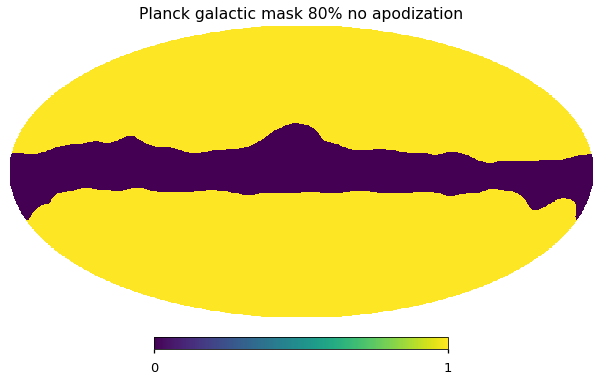

In [11]:
hp.mollview(planck_gal80_mask, title="Planck galactic mask 80% no apodization")

We need to downgrade the Planck mask from 2048 to 1024, so we average 4 pixels, we consider a pixel un-masked if 3 of the 4 pixels are unmasked.

In [12]:
# total_mask = np.logical_and(hp.ud_grade(wmap_mask, nside), hp.ud_grade(planck_gal80_mask, nside)>=.75)

We can check how many pixels have the value of 0,0.25,0.5,0.75,1

In [13]:
np.bincount((4*hp.ud_grade(planck_gal80_mask, nside)).astype(np.int64))

array([ 2511882,     3288,     1665,     3317, 10062760])

In [14]:
total_mask = hp.ud_grade(planck_gal80_mask, nside)>=.75

In [15]:
hp.write_map("total_mask.fits", total_mask.astype(np.int), overwrite=True)

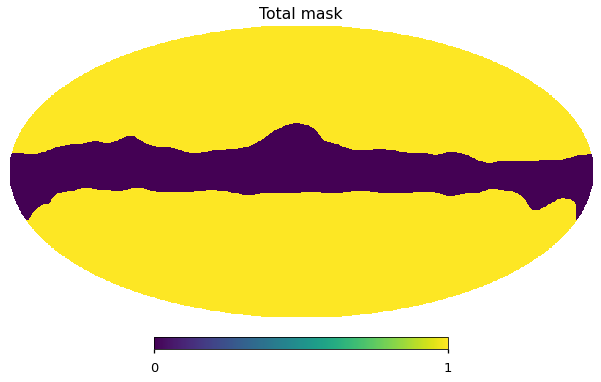

In [16]:
hp.mollview(total_mask, title="Total mask")

## Download the dust polarization map from Planck / Commander

Download the dust polarization map from Commander, see:

https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/previews/COM_CompMap_DustPol-commander_1024_R2.00/index.html

We are trying to reproduce the PySM 2 results so we are using the Commander release 2 results. Later on we can switch to the last Planck release.

In [17]:
commander_dust_map_filename = "COM_CompMap_DustPol-commander_1024_R2.00.fits"

In [18]:
if not os.path.exists(commander_dust_map_filename):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/foregrounds/$commander_dust_map_filename

The input map has no temperature, we repeat the Q component for T as well,
this doesn't impact the polarization spectra:

In [19]:
m_planck,h = hp.read_map("./COM_CompMap_DustPol-commander_1024_R2.00.fits", (0,0,1), h=True)

In [20]:
h

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 56),
 ('NAXIS2', 12582912),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 14),
 ('COMMENT', ''),
 ('COMMENT', ' *** End of mandatory fields ***'),
 ('COMMENT', ''),
 ('EXTNAME', 'COMP-MAP-DustPol'),
 ('EXTVER', 1),
 ('DATE', '2014-12-11'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Column names ***'),
 ('COMMENT', ''),
 ('TTYPE1', 'Q_ML_FULL'),
 ('TTYPE2', 'U_ML_FULL'),
 ('TTYPE3', 'Q_ML_HM1'),
 ('TTYPE4', 'U_ML_HM1'),
 ('TTYPE5', 'Q_ML_HM2'),
 ('TTYPE6', 'U_ML_HM2'),
 ('TTYPE7', 'Q_ML_HR1'),
 ('TTYPE8', 'U_ML_HR1'),
 ('TTYPE9', 'Q_ML_HR2'),
 ('TTYPE10', 'U_ML_HR2'),
 ('TTYPE11', 'Q_ML_YR1'),
 ('TTYPE12', 'U_ML_YR1'),
 ('TTYPE13', 'Q_ML_YR2'),
 ('TTYPE14', 'U_ML_YR2'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Column formats ***'),
 ('COMMENT', ''),
 ('TFORM1', 'E'),
 ('TFORM2', 'E'),
 ('TFORM3', 'E'),
 ('TFORM4', 'E'),
 ('TFORM5', 'E'),
 ('TFORM6', 'E'),
 ('TFORM7', 'E'),
 ('TFORM8', 'E'),
 ('TFORM9', 'E'),
 ('TFORM10', 'E'),
 

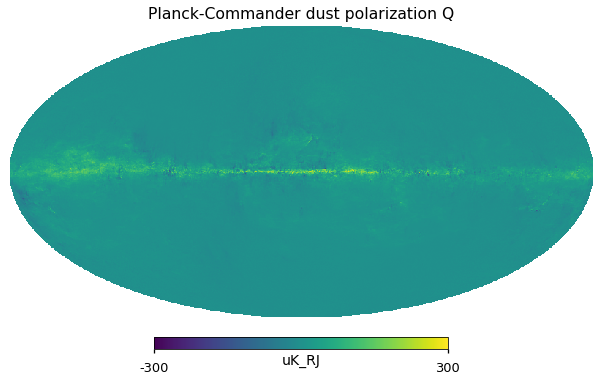

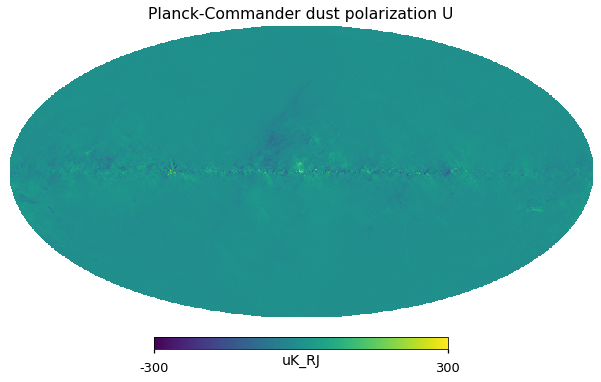

In [21]:
for i_pol, pol in [(1, "Q"), (2, "U")]:
    hp.mollview(m_planck[i_pol], title="Planck-Commander dust polarization " + pol, unit="uK_RJ", min=-300, max=300)

In [22]:
# A T map set to 0 is not supported by PolSpice
m_planck[0] = 1

## Extend spectrum to small scales



### Angular power spectrum with NaMaster

In [23]:
import pymaster as nmt

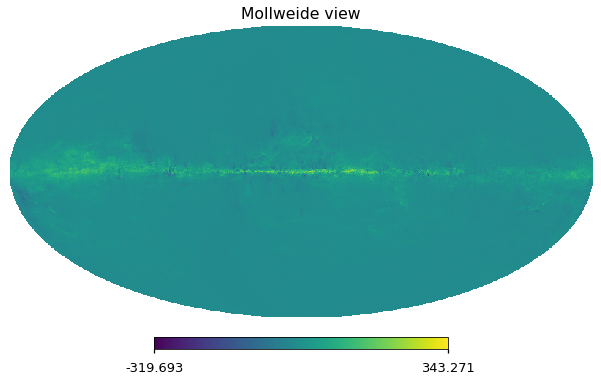

In [24]:
hp.mollview(m_planck[1])

In [25]:
def run_namaster(m, mask):
    binning = nmt.NmtBin.from_nside_linear(hp.npix2nside(m.shape[-1]), 1)
    ell_arr = binning.get_effective_ells()
    ell_arr = np.concatenate([[0,0], ell_arr])
    f_2 = nmt.NmtField(mask, m.copy()) # namaster overwrites the map in place with the mask
    cl_22 = nmt.compute_full_master(f_2, f_2, binning)
    cl = np.zeros((3, len(ell_arr)), dtype=np.double)
    cl[1, 2:] = cl_22[0]
    cl[2, 2:] = cl_22[3]
    return ell_arr, cl

In [26]:
ell_arr, spice_cl = run_namaster(m_planck[1:], total_mask)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


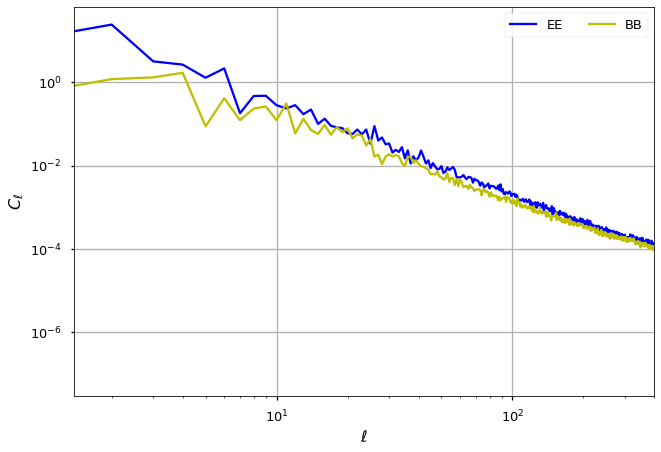

In [28]:
plt.plot(ell_arr, spice_cl[1], 'b-', label='EE')
plt.plot(ell_arr, spice_cl[2], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.grid()
plt.xlim([0, 400])
plt.show()

In [29]:
ell = np.arange(spice_cl.shape[1])
cl_norm = ell*(ell+1)/np.pi/2

We plot the output power spectrum and also identify a range in $\ell$ before white noise starts dominating
and after the uncertainty at low-$\ell$.

The power spectrum features a power law behaviour $\ell < 200$ (linear in `loglog` axes), then white noise
starts picking up until $\ell=1000$ and then we see the smoothing applied to the maps (10 arcminutes).

In [30]:
ell_fit_low = 50
ell_fit_high = 200

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


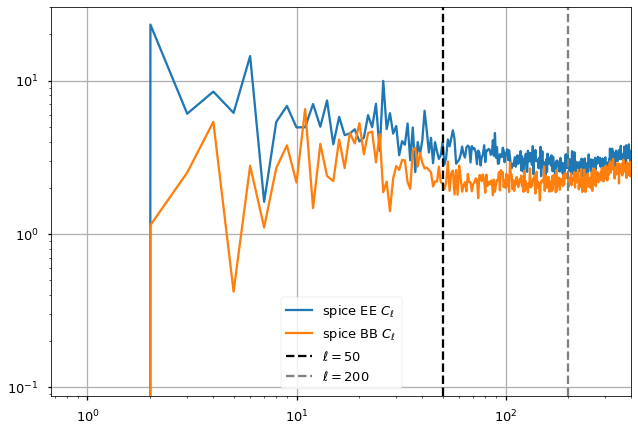

In [31]:
plt.loglog(cl_norm * spice_cl[1], label="spice EE $C_\ell$")
plt.loglog(cl_norm * spice_cl[2], label="spice BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
plt.legend()
plt.xlim([0, 400])
plt.grid();

### Fit noise bias

We want to fit for the high-ell slope so that we can extend that to higher ells, but the spectrum
especially BB is dominated by noise, therefore we first fit an estimate of the noise at high ell
and substract it out.

To do this we first "unsmooth" the map by the 10 arcmin beam used by Commander and then
average where we see the spectrum flattening out.
There are many parameters here we can tweak, the target here is just to check we can recover something
similar to the PySM 2 paper.

In [32]:
smoothing_beam = hp.gauss_beam(fwhm=(10 * u.arcmin).to_value(u.radian), lmax=lmax)

In [33]:
noise_bias = (spice_cl[1:, 750:850] / smoothing_beam[750:850]**2).mean(axis=1)

In [34]:
noise_bias = {"EE":noise_bias[0], "BB":noise_bias[1]}

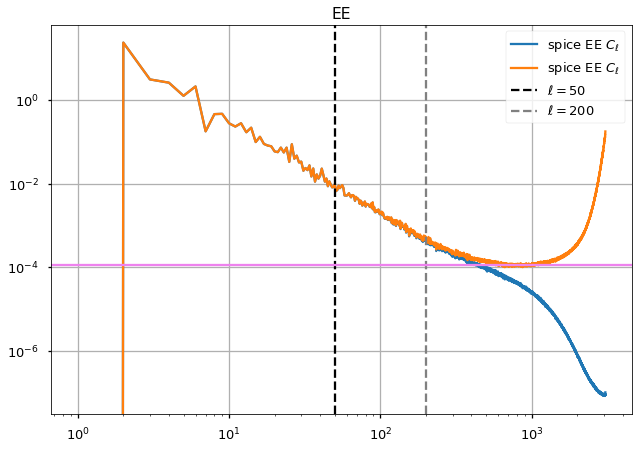

In [35]:
plt.title("EE")
plt.loglog(spice_cl[1], label="spice EE $C_\ell$")
#plt.loglog(spice_cl[2], label="spice BB $C_\ell$")
plt.loglog(spice_cl[1]/smoothing_beam**2, label="spice EE $C_\ell$")

plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
plt.legend()
for pol,color in zip(["EE", ], ["violet", ]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
#plt.xlim([0, 400])
plt.grid();

In [36]:
noise_bias

{'EE': 0.00011287208896345207, 'BB': 0.00010224582025317983}

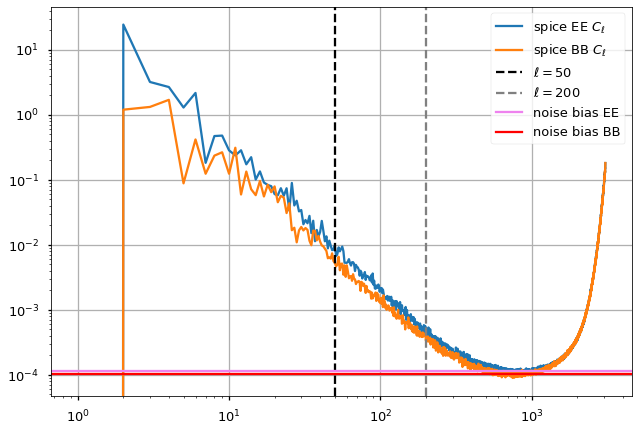

In [37]:
plt.loglog(spice_cl[1]/smoothing_beam**2, label="spice EE $C_\ell$")
plt.loglog(spice_cl[2]/smoothing_beam**2, label="spice BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
for pol,color in zip(["EE", "BB"], ["violet", "red"]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
plt.legend()
plt.grid();

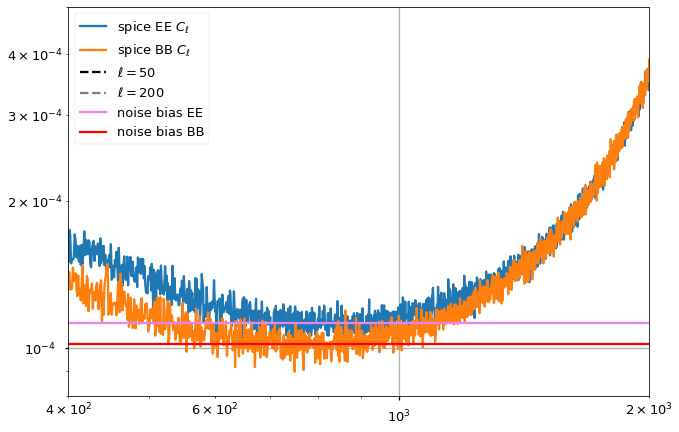

In [38]:
plt.loglog(spice_cl[1]/smoothing_beam**2, label="spice EE $C_\ell$")
plt.loglog(spice_cl[2]/smoothing_beam**2, label="spice BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
for pol,color in zip(["EE", "BB"], ["violet", "red"]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
plt.legend()
plt.xlim([4e2, 2e3])
plt.ylim([8e-5, 5e-4])
plt.grid();

### Fit for the slope at high ell

We assume the same model from the paper and fit for an amplitude and a power law exponent (slope in log-log)

In [39]:
from scipy.optimize import curve_fit

In [40]:
def model(ell, A, gamma):
    return A * ell ** gamma

In [41]:
xdata = np.arange(ell_fit_low, ell_fit_high)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


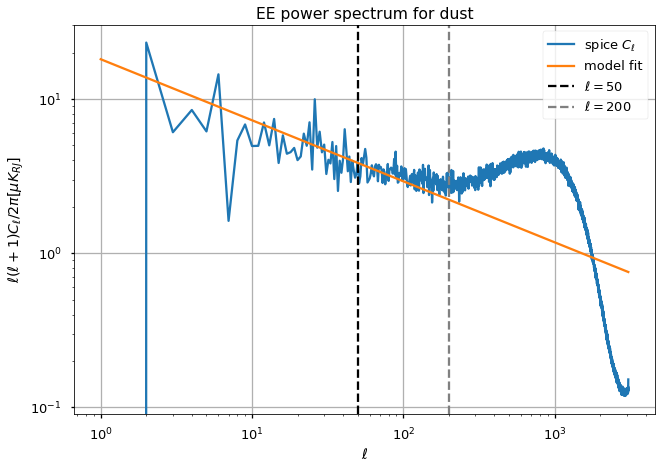

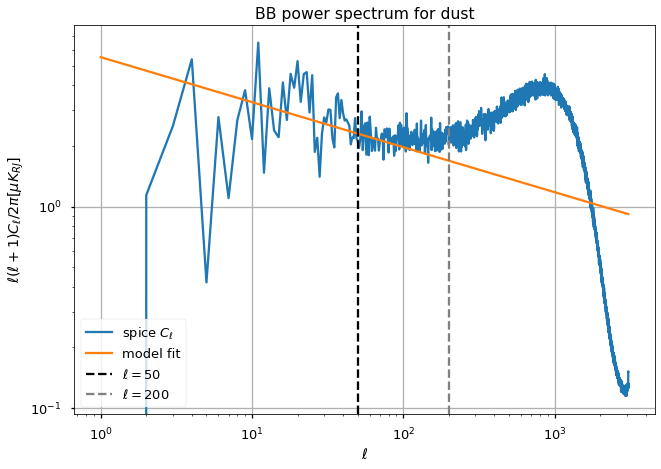

In [42]:
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
for pol,i_pol in [("EE",1),("BB",2)]:
    ydata = xdata*(xdata+1)/np.pi/2 * (spice_cl[i_pol][xdata] - noise_bias[pol])
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.figure()
    plt.loglog(ell*(ell+1)/np.pi/2 * (spice_cl[i_pol] ), label="spice $C_\ell$")

    plt.loglog(A_fit[pol]*ell**gamma_fit[pol], label="model fit")
    plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
    plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
    plt.legend()
    plt.grid()
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))

    plt.title(f"{pol} power spectrum for dust")
    #plt.xlim(0, 400)
    #plt.ylim(1, 30);

In [43]:
A_fit, A_fit_std

({'EE': 18.09672573027622, 'BB': 5.518135999977027},
 {'EE': 2.216649476829414, 'BB': 0.6670108771575787})

In [44]:
gamma_fit, gamma_fit_std

({'EE': -0.3957026535575404, 'BB': -0.22333811471731838},
 {'EE': 0.026341585170764382, 'BB': 0.025694460083852243})

The paper mentions a $\gamma^{EE,dust} = -.31$ and a $\gamma^{BB,dust} = -.15$.


### Window function

The window function is used to smooth the input templates to remove the high $\ell$ noise and its inverse is used for the added small scales.

$\ell_*^{dust}$

In [45]:
ell_star = 69

In [46]:
theta_fwhm_deg = 180/ell_star

In [47]:
theta_fwhm_deg

2.608695652173913

In [48]:
theta_fwhm = np.radians(theta_fwhm_deg)

In [49]:
w_ell = hp.gauss_beam(fwhm=theta_fwhm, lmax=lmax)

In [50]:
w_ell.shape

(3072,)

### Process patches

This process doesn't have a large impact on the output spectra, the idea is that in each $N_{side}=2$ pixel we want to scale the gaussian fluctuations so that they are consistent with the power at low ell.
So we will have higher gaussian fluctuations on the galaxy where there is stronger dust emission.

In [51]:
patch_indices = hp.ud_grade(np.arange(hp.nside2npix(2)), nside)

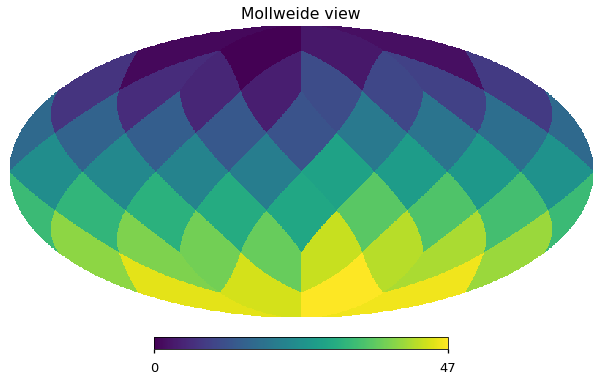

In [52]:
hp.mollview(patch_indices)

In [53]:
zeros = np.zeros(len(ell), dtype=np.double)

In [54]:
inv_w_ell = 1 - w_ell**2

In [55]:
nside_patches = 2
n_patches = hp.nside2npix(nside_patches)

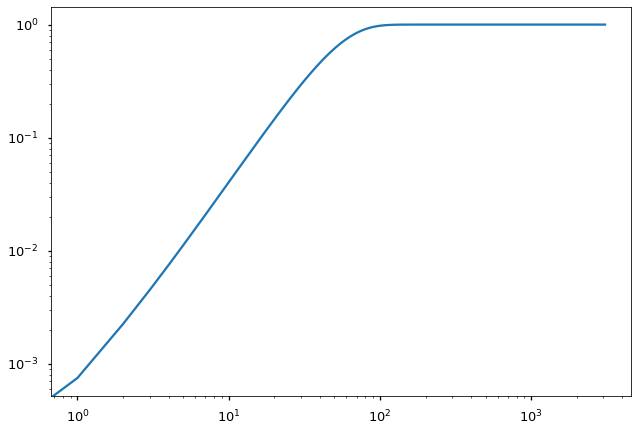

In [56]:
plt.loglog(inv_w_ell)

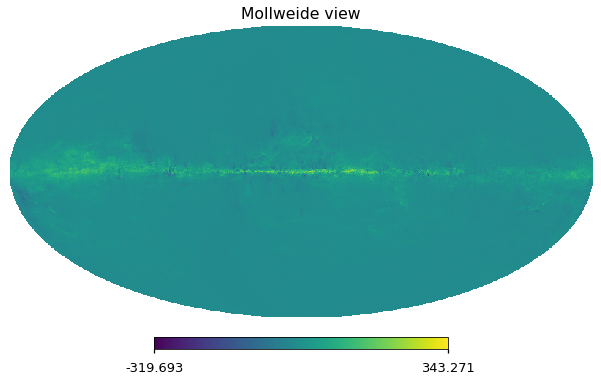

In [57]:
hp.mollview(m_planck[1])

In [58]:
m_sigma_G = hp.synfast([
    zeros,
    A_fit["EE"] * ell**gamma_fit["EE"] * inv_w_ell / cl_norm,A_fit["BB"] * ell**gamma_fit["BB"] * inv_w_ell / cl_norm,
    zeros, zeros, zeros], nside, new=True)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


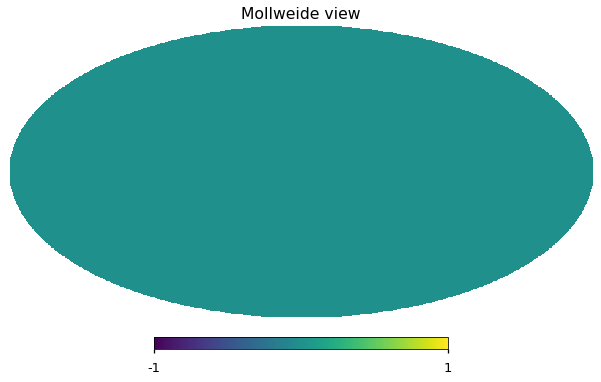

In [59]:
hp.mollview(m_sigma_G[0])

In [60]:
N = {i_pol:np.zeros(n_patches, dtype=np.double) for i_pol in [1,2]}

In [61]:
m_planck[0] = 0

In [62]:
m_planck_smoothed = hp.alm2map(hp.smoothalm(hp.map2alm(m_planck, use_pixel_weights=True), fwhm=theta_fwhm),
                               nside=nside)

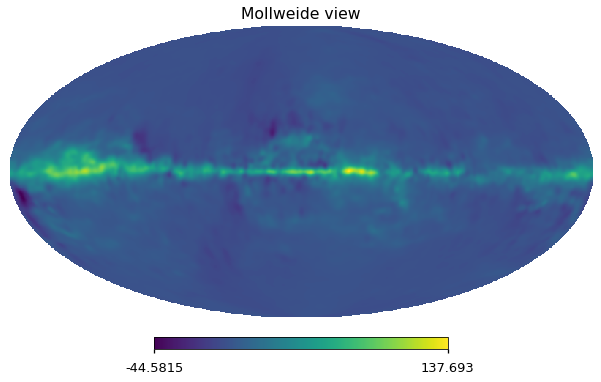

In [63]:
hp.mollview(m_planck_smoothed[1])

In [64]:
for i_patch in range(n_patches):
    print(i_patch)
    m_patch = np.zeros_like(m_planck_smoothed)
    m_patch[1:, patch_indices == i_patch] = m_planck_smoothed[1:, patch_indices == i_patch]
    cl_patch = hp.anafast(m_patch, lmax=2*ell_star, use_pixel_weights=True)
    for pol,i_pol in [("EE", 1),("BB",2)]:
        N[i_pol][i_patch] = np.sqrt(cl_patch[i_pol][ell_star] / n_patches / (A_fit[pol] * ell_star ** gamma_fit[pol]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


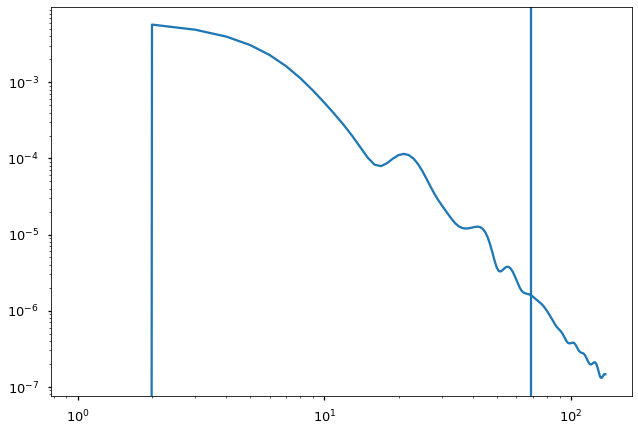

In [65]:
plt.loglog(cl_patch[1])
plt.axvline(ell_star)

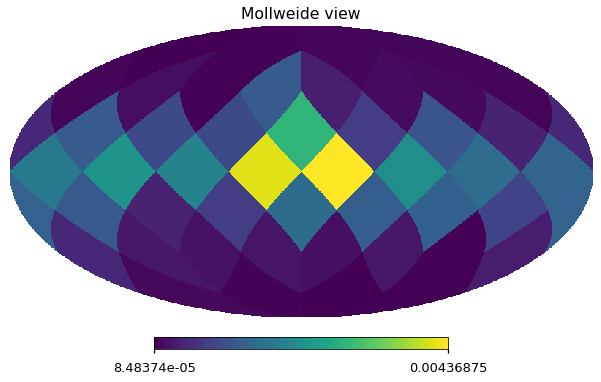

In [66]:
hp.mollview(N[1])

In [67]:
m_zeros = np.zeros(hp.nside2npix(nside), dtype=np.double)

In [68]:
N_smoothed = hp.smoothing([m_zeros, hp.ud_grade(N[1], nside), hp.ud_grade(N[2], nside)], fwhm=np.radians(10))

In [69]:
N_smoothed[1] /= N_smoothed[1].mean()

In [70]:
N_smoothed[2] /= N_smoothed[2].mean() 

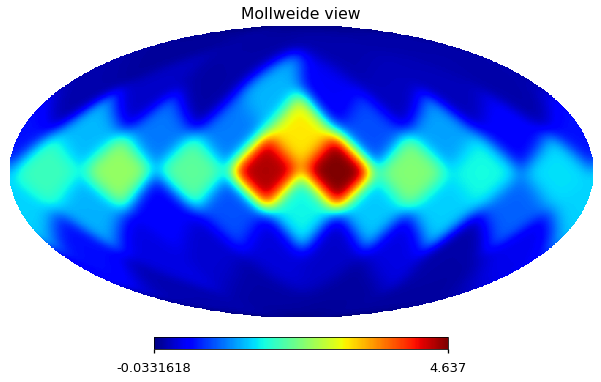

In [71]:
hp.mollview(N_smoothed[1], cmap="jet")

This also is quite different from Figure 9 in the paper, but it is not the main issue, possibly I need to use PolSpice instead of anafast?

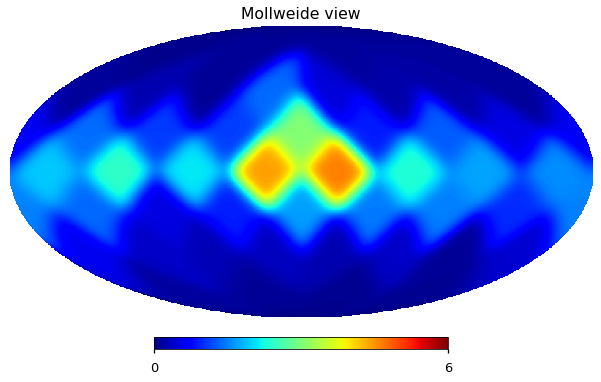

In [72]:
hp.mollview(N_smoothed[1], min=0, max=6, cmap="jet")

## Run PolSpice on the total map and just on the small scales

Always using the same Gal80 Planck mask

In [73]:
m_total = m_planck_smoothed + m_sigma_G * N_smoothed

In [74]:
m_total[0] = 1

In [75]:
_, cl_total = run_namaster(m_total[1:], total_mask)

In [76]:
m_sigma_G[0]=1

In [77]:
N_smoothed[0]=1

In [78]:
_, cl_sigma_G_uniform = run_namaster(m_sigma_G[1:], total_mask)

## Download PySM 2 templates

In [79]:
for comp in "tqu":
    filename = f"dust_{comp}_new.fits"
    if not os.path.exists(filename):
        !wget https://portal.nersc.gov/project/cmb/pysm-data/pysm_2/$filename

In [80]:
total_mask.shape

(12582912,)

In [81]:
total_mask_512 = hp.ud_grade(total_mask, 512)>=.75

In [82]:
m_pysm2 = np.array([hp.read_map(f"dust_{comp}_new.fits") for comp in "tqu"])

In [83]:
ell_arr_512, cl_pysm2 = run_namaster(m_pysm2[1:], total_mask_512)

### Check the impact of modifying the amplitude across the sky

It has the effect of increasing how steeply the spectrum decreases at low-ell
this has the same impact we can see on the plot in the paper copied at the bottom
of the Notebook, the red line which is the fitted spectrum is less steep than
the actual small scale realization.

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


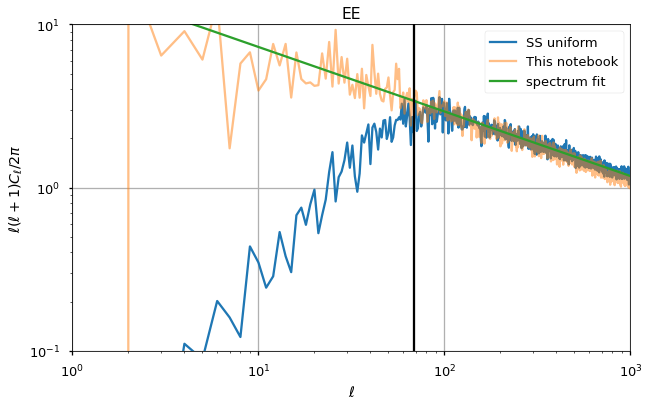

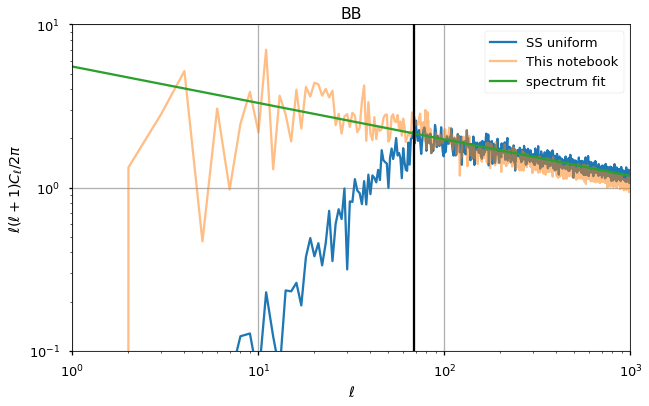

In [84]:
for pol, i_pol in [("EE",1),("BB",2)]:
    plt.figure(figsize=(10,6))
    #plt.loglog(cl_norm[:cl_pysm2.shape[1]]*cl_pysm2[i_pol], label="pysm2")
    plt.loglog(cl_norm*cl_sigma_G_uniform[i_pol], label="SS uniform")
    plt.loglog(cl_norm*cl_total[i_pol], label="This notebook", alpha=.5)

    #plt.loglog(cl_norm*spice_cl[i_pol], label="original")

    plt.loglog(A_fit[pol] * ell**gamma_fit[pol], label="spectrum fit")
    plt.axvline(ell_star, color="black")
    plt.title(pol)
    plt.legend()
    plt.xlim([1,1000])
    plt.ylim([1e-1, 1e1])
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi$")
    plt.xlabel("$\ell$")
    plt.grid();

## Compare PySM 2, the input and the output

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


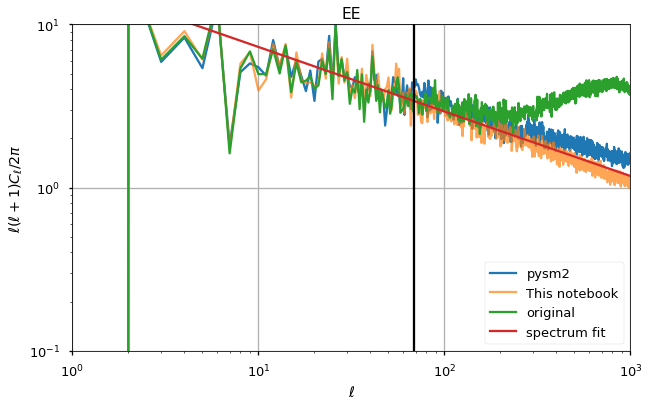

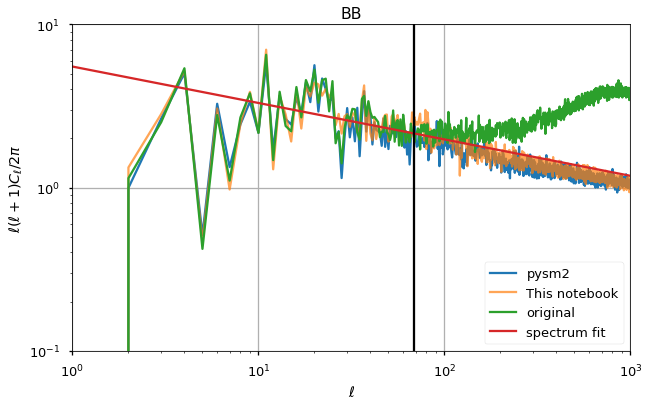

In [85]:
for pol, i_pol in [("EE",1),("BB",2)]:
    plt.figure(figsize=(10,6))
    plt.loglog(cl_norm[:cl_pysm2.shape[1]]*cl_pysm2[i_pol], label="pysm2")
    #plt.loglog(cl_norm*cl_sigma_G_uniform[i_pol], label="SS uniform")
    plt.loglog(cl_norm*cl_total[i_pol], label="This notebook", alpha=.7)

    plt.loglog(cl_norm*spice_cl[i_pol], label="original")

    plt.loglog(A_fit[pol] * ell**gamma_fit[pol], label="spectrum fit")
    plt.axvline(ell_star, color="black")
    plt.title(pol)
    plt.legend()
    plt.xlim([1,1000])
    plt.ylim([1e-1, 1e1])
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi$")
    plt.xlabel("$\ell$")
    plt.grid();

We can also compare with the dust BB plot (Figure 7) from the PySM 2 paper below

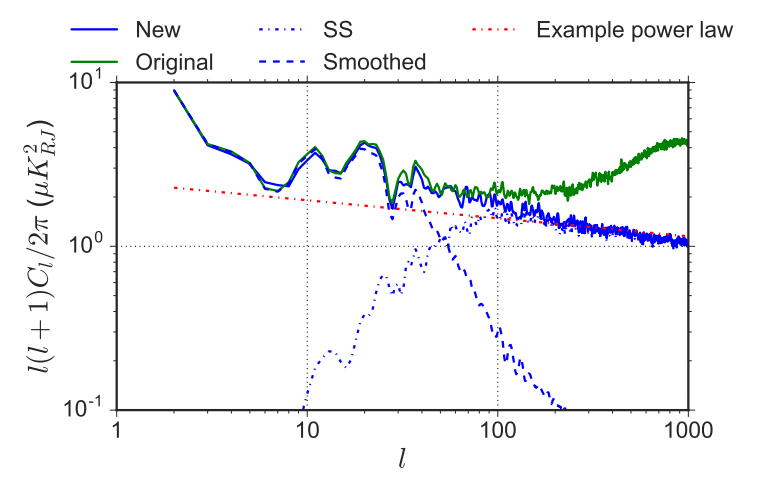

In [86]:
from IPython.display import Image
Image("BB_dust_PySM_2_paper.png")

# 